## Sandwich_maps_local_coords

Read DEMS and convert to rotated alongshore/cross-shore coordinate systems.

Save as .nc files.



In [1]:

import numpy as np
#import pandas as pd
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from scipy import interpolate, signal

import xarray as xr
%matplotlib inline

In [2]:
fdir = "F:/2017_Karen_Sandwich_maps/"
#fdir = "C:/crs/proj/2017_Karen_Sandwich_maps"

fnames = (\
"2016-01-22_SandwichTNB_PT_DEM_10cm_trimmed.tif",\
"2016-01-25_SandwichTNB_DEM_10cm_trimmed.tif",\
"2016-02-11_SandwichTNB_DEM_10cm_trimmed.tif",\
"2016-03-30_SandwichTNB_AS_DEM_10cm_trimmed.tif",\
"2016-09-21_SandwichTNB_DEM_10cm_trimmed.tif",\
"2017-01-09_SandwichTNB_DEM_10cm_trimmed.tif",\
"2017-01-25_SandwichTNB_DEM_10cm_trimmed.tif",\
"2017-02-14_SandwichTNB_DEM_10cm_trimmed.tif",\
"2017-03-16_SandwichTNB_DEM_10cm_trimmed.tif",\
"2017-04-28_SandwichTNB_DEM_10cm_trimmed.tif",\
"2017-05-04_SandwichTNB_DEM_10cm_trimmed.tif",\
"2017-09-18_SandwichTNB_DEM_10cm_trimmed.tif",\
#"2018-01-03_SandwichTNB_DEM_10cm_trimmed.tif",\ # needs to be padded...not very good control
"2018-01-10_SandwichTNB_DEM_10cm_trimmed.tif",\
"DEM_10cm_selfcal_lokicampos_mid_denseNAD83UTM19.tif")

# list of dates for use as titles / column headers
titles = ([\
         "22-Jan-2016",\
         "25-Jan-2016",\
         "11-Feb-2016",\
         "30-Mar-2016",\
         "21-Sep-2016",\
         "09-Jan-2017",\
         "25-Jan-2017",\
         "14-Feb-2017",\
         "16-Mar-2017",\
         "28-Apr-2017",\
         "04-May_2017",\
         "18-Sep-2017",\
#         "03-Jan-2017",\
         "10-Jan-2018",\
         "09-Mar-2018"])

nf=len(fnames)

In [3]:
def box2UTMh(x, y, x0, y0, theta):
    '''
    2D rotation and translation of x, y
    Input:
        x, y - row vectors of original coordinates (must be same size)
        x0, y0 - Offset (location of x, y = (0,0) in new coordinate system)
        theta - Angle of rotation (degrees, CCW from x-axis == Cartesian coorinates)
    Returns:
        xr, yr - rotated, offset coordinates
    '''
    thetar = np.radians(theta)
    c, s = np.cos(thetar), np.sin(thetar)

    # homogenous rotation matrix
    Rh = np.array(((c, -s,  0.),\
                   (s,  c,  0.),\
                   (0., 0., 1.)))
    # homogenous translation matrix
    Th = np.array(((1., 0., x0),\
                   (0., 1., y0),\
                   (0., 0., 1.)))
    
    # homogenous input x,y
    xyh = np.vstack((x,y,np.ones_like(x)))

    # perform rotation and translation
    xyrh=np.matmul(np.matmul(Th,Rh),xyh)
    xr = xyrh[0,:]
    yr = xyrh[1,:]
    return xr, yr

### Make small box with local alongshore/cross-shore coordinates that will be our region of interest (ROI)

In [4]:
# make a small box w/ cell centered grid with spacing dxy
dxy = 1.
xmax = 280. # alongshore
ymax = 1300.  # cross-shore
nx = int((1./dxy)*xmax)
ny = int((1./dxy)*ymax)

# kernal size for smoothing original map...this should be an odd number >= dxy/0.1
ksize = 11 

# Y is ascending
xrot, yrot=np.meshgrid(np.linspace(0.5*dxy,xmax-0.5*dxy,nx), np.linspace(0.5*dxy,ymax-0.5*dxy,ny) ,sparse=False, indexing='xy')
print("xrot:")
print(xrot.shape)
print(xrot)
print("yrot:")
print(yrot.shape)
print(yrot)

xrot:
(1300, 280)
[[   0.5    1.5    2.5 ...,  277.5  278.5  279.5]
 [   0.5    1.5    2.5 ...,  277.5  278.5  279.5]
 [   0.5    1.5    2.5 ...,  277.5  278.5  279.5]
 ..., 
 [   0.5    1.5    2.5 ...,  277.5  278.5  279.5]
 [   0.5    1.5    2.5 ...,  277.5  278.5  279.5]
 [   0.5    1.5    2.5 ...,  277.5  278.5  279.5]]
yrot:
(1300, 280)
[[  5.00000000e-01   5.00000000e-01   5.00000000e-01 ...,   5.00000000e-01
    5.00000000e-01   5.00000000e-01]
 [  1.50000000e+00   1.50000000e+00   1.50000000e+00 ...,   1.50000000e+00
    1.50000000e+00   1.50000000e+00]
 [  2.50000000e+00   2.50000000e+00   2.50000000e+00 ...,   2.50000000e+00
    2.50000000e+00   2.50000000e+00]
 ..., 
 [  1.29750000e+03   1.29750000e+03   1.29750000e+03 ...,   1.29750000e+03
    1.29750000e+03   1.29750000e+03]
 [  1.29850000e+03   1.29850000e+03   1.29850000e+03 ...,   1.29850000e+03
    1.29850000e+03   1.29850000e+03]
 [  1.29950000e+03   1.29950000e+03   1.29950000e+03 ...,   1.29950000e+03
    1.29950000

### Convert ROI to UTM coordinates

In [5]:
# Define the ROI with bottom left corner and rotation of axes
e0 = 377270.; n0 = 4624440.
rot = 52.

print('Shape of xrot, yrot: ',np.shape(xrot),np.shape(xrot))
shp = np.shape(xrot)
xu, yu = box2UTMh(xrot.flatten(), yrot.flatten(), e0, n0, rot)
xu=np.reshape(xu,shp)
yu=np.reshape(yu,shp)
print('Shape of xu and yu: ',np.shape(xu),np.shape(yu))

Shape of xrot, yrot:  (1300, 280) (1300, 280)
Shape of xu and yu:  (1300, 280) (1300, 280)


### Loop through the maps and interpolate onto the rotated coordinate system
Some of the DEMS have holes w/ NaNs.

Here is one option for smoothing the raw data before interpolating:
https://stackoverflow.com/questions/18697532/gaussian-filtering-a-image-with-nan-in-python

In [6]:
%%time
dslist=[]
for i in range(nf):
    fn = fdir+fnames[i]
    print(i, fn)
    
    # open the tif with XArray as a DataArray
    da = xr.open_rasterio(fn)
    
    print( np.shape(np.flipud(da['y'].values)), np.shape(da['x'].values), np.shape( np.flipud(da.values)) )
    x = da['x'].values
    y = np.flipud(da['y'].values)
    
    # Not sure how da.values got a singleton dimension, but squeeze gets rid of it.
    # However, make sure to squeeze before flipping
    z = np.flipud(np.squeeze(da.values))
    print(np.shape(x),np.shape(y),np.shape(z))
    
    # smooth with 2D running median
    zs = signal.medfilt2d(z, kernel_size=ksize)
    
    f = interpolate.RegularGridInterpolator( (y, x), zs, method='linear')   
    
    # Array for interpolated elevations
    zi=np.NaN*np.ones((ny,nx))

    # this is a slow iteration through all of the points, but allows us to skip ones that are outside
    for ij in np.ndindex(zi.shape):
        try:
            zi[ij]=f((yu[ij],xu[ij]))
        except:
            zi[ij]=np.NaN
            
    da = xr.DataArray(zi)
    # dslist.append(da.chunk()) # this does not work...can't concatenate a method
    da = da.chunk()
    dslist.append(da)

0 F:/2017_Karen_Sandwich_maps/2016-01-22_SandwichTNB_PT_DEM_10cm_trimmed.tif
(10226,) (11987,) (1, 10226, 11987)
(11987,) (10226,) (10226, 11987)
1 F:/2017_Karen_Sandwich_maps/2016-01-25_SandwichTNB_DEM_10cm_trimmed.tif
(10156,) (11420,) (1, 10156, 11420)
(11420,) (10156,) (10156, 11420)
2 F:/2017_Karen_Sandwich_maps/2016-02-11_SandwichTNB_DEM_10cm_trimmed.tif
(10204,) (11673,) (1, 10204, 11673)
(11673,) (10204,) (10204, 11673)
3 F:/2017_Karen_Sandwich_maps/2016-03-30_SandwichTNB_AS_DEM_10cm_trimmed.tif
(9858,) (11504,) (1, 9858, 11504)
(11504,) (9858,) (9858, 11504)
4 F:/2017_Karen_Sandwich_maps/2016-09-21_SandwichTNB_DEM_10cm_trimmed.tif
(12379,) (12221,) (1, 12379, 12221)
(12221,) (12379,) (12379, 12221)
5 F:/2017_Karen_Sandwich_maps/2017-01-09_SandwichTNB_DEM_10cm_trimmed.tif
(10491,) (11301,) (1, 10491, 11301)
(11301,) (10491,) (10491, 11301)
6 F:/2017_Karen_Sandwich_maps/2017-01-25_SandwichTNB_DEM_10cm_trimmed.tif
(10175,) (11191,) (1, 10175, 11191)
(11191,) (10175,) (10175, 1119

In [7]:
dsa = xr.concat(dslist, dim='map')

In [8]:
dsa

<xarray.DataArray (map: 14, dim_0: 1300, dim_1: 280)>
dask.array<shape=(14, 1300, 280), dtype=float64, chunksize=(1, 1300, 280)>
Dimensions without coordinates: map, dim_0, dim_1

In [9]:
dsa.to_netcdf('one_meter_test.nc')

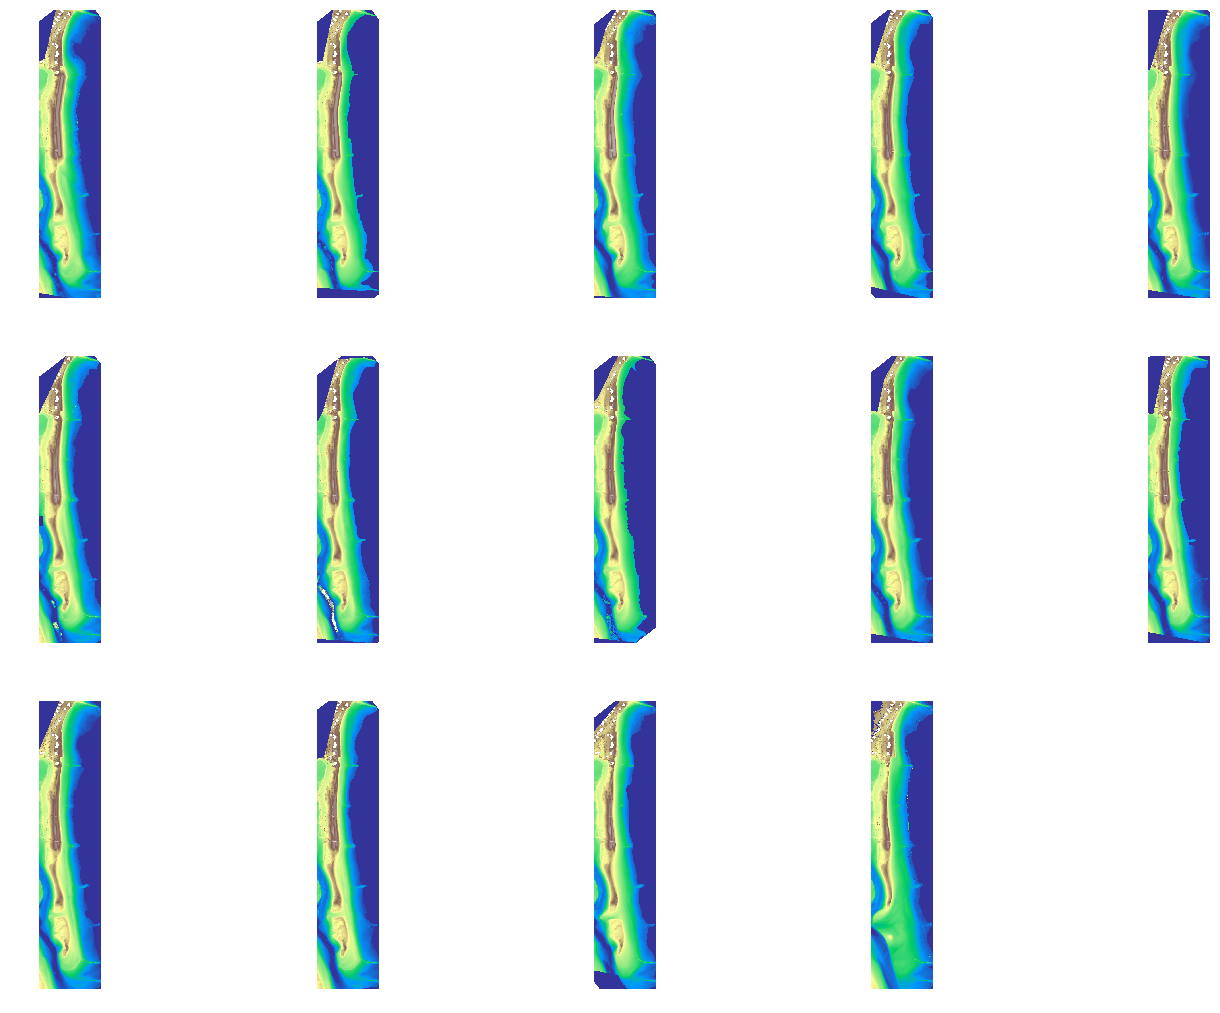

In [10]:
# declare a plot size
plt.subplots(figsize=(24,18))

for i in range(nf):
    # small plots of elevation
    plt.subplot(3,5,i+1); plt.axis('off'); plt.imshow(np.flipud(dsa[i,:,:]),cmap=plt.cm.terrain,vmin=-2,vmax=8)

In [11]:
dsa

<xarray.DataArray (map: 14, dim_0: 1300, dim_1: 280)>
dask.array<shape=(14, 1300, 280), dtype=float64, chunksize=(1, 1300, 280)>
Dimensions without coordinates: map, dim_0, dim_1